Scope acquisition
=================

In this tutorial we will demonstrate the sequencer based scope acquisition procedure allowing you to inspect and process the raw input
of the QRM. We will also have a look at how to average multiple scope acquisitions in hardware (see section [Acquisition](https://qblox-qblox-instruments.readthedocs-hosted.com/en/master/documentation/sequencer.html#acquisitions)). We will show this by using a QRM and directly connecting outputs 
$\text{O}^{[1-2]}$ to inputs $\text{I}^{[1-2]}$ respectively. We will then use the QRM's sequencers to sequence waveforms on 
the outputs and simultaneously acquire the resulting waveforms on the inputs.


To run this tutorial please make sure you have installed and enabled ipywidgets: 
```
pip install ipywidgets
jupyter nbextension enable -–py widgetsnbextension
```

Setup
-----

First, we are going to import the required packages.

In [1]:
# Import ipython widgets
import json
import math
import os

import ipywidgets as widgets
import matplotlib.pyplot
import numpy

# Set up the environment.
import scipy.signal
from IPython.display import display
from ipywidgets import fixed, interact, interact_manual, interactive

from qblox_instruments import Cluster, PlugAndPlay, Pulsar

### Scan For Devices

We scan for the available devices connected via ethernet using the Plug & Play functionality of the Qblox Instruments package (see [Plug & Play](https://qblox-qblox-instruments.readthedocs-hosted.com/en/master/api_reference/pnp.html) for more info).

In [ ]:
# Scan for available devices and display
with PlugAndPlay() as p:
    # get info of all devices
    device_list = p.list_devices()
    device_keys = list(device_list.keys())

# create widget for names and ip addresses
connect = widgets.Dropdown(
    options=[(device_list[key]["description"]["name"]) for key in device_list.keys()],
    description="Select Device",
)
print(
    "The following widget displays all the existing modules that are connected to your PC which includes the Pulsar modules as well as a Cluster. Select the device you want to run the notebook on."
)
display(connect)

#### Pulsar QRM <a id='pulsar_setup'></a>
Choose the Pulsar QRM and run the following cell. Skip to the [Cluster QRM section](#cluster_setup) if you selected a Cluster module.

In [ ]:
# Close existing connections to the Pulsar modules
Pulsar.close_all()

# Retrieve device name and IP address
device_name = connect.value
device_number = connect.options.index(device_name)
ip_address = device_list[device_keys[device_number]]["identity"]["ip"]

# Connect to device and reset
qrm = Pulsar(f"{device_name}", ip_address)
qrm.reset()
print(f"{device_name} connected at {ip_address}")
print(qrm.get_system_state())

Skip to the next section [(Generate Waveform)](#gen_wf) if you are not using a cluster. 

#### Cluster QRM <a id='cluster_setup'></a>
First we connect to the Cluster using its IP address. Go to the [Pulsar QRM section](#pulsar_setup) if you are using a Pulsar.


In [ ]:
# close all previous connections to the cluster
Cluster.close_all()

# Retrieve device name and IP address
device_name = connect.value
device_number = connect.options.index(device_name)
ip_address = device_list[device_keys[device_number]]["identity"]["ip"]


# connect to the cluster and reset
cluster = Cluster(device_name, ip_address)
cluster.reset()
print(f"{device_name} connected at {ip_address}")

We then find all available cluster modules to connect to them individually.

In [ ]:
# Find all QRM/QCM modules
available_slots = {}
for module in cluster.modules:
    # if module is currently present in stack
    if cluster._get_modules_present(module.slot_idx):
        # check if QxM is RF or baseband
        if module.is_rf_type:
            available_slots[f"module{module.slot_idx}"] = ["QCM-RF", "QRM-RF"][
                module.is_qrm_type
            ]
        else:
            available_slots[f"module{module.slot_idx}"] = ["QCM", "QRM"][
                module.is_qrm_type
            ]

# List of all QxM modules present
connect_qxm = widgets.Dropdown(options=[key for key in available_slots.keys()])

print(available_slots)
# display widget with cluster modules
print()
print("Select the QRM module from the available modules in your Cluster:")
display(connect_qxm)

Finally, we connect to the selected Cluster module. 

In [50]:
# Connect to the cluster QRM
qrm = getattr(
    cluster, connect_qxm.value
)  # Connect to the module that you have chosen above
print(f"{available_slots[connect_qxm.value]} connected")
print(cluster.get_system_state())

QRM connected
Status: OKAY, Flags: NONE, Slot flags: NONE


Generate waveforms <a id='gen_wf'></a>
------------------

Next, we need to create the gaussian and block waveforms for the sequence.

In [5]:
# Waveform parameters
waveform_length = 120  # nanoseconds

# Waveform dictionary (data will hold the samples and index will be used to select the waveforms in the instrument).
waveforms = {
    "gaussian": {
        "data": scipy.signal.gaussian(
            waveform_length, std=0.12 * waveform_length
        ).tolist(),
        "index": 0,
    },
    "sine": {
        "data": [
            math.sin((2 * math.pi / waveform_length) * i)
            for i in range(0, waveform_length)
        ],
        "index": 1,
    },
}

Let's plot the waveforms to see what we have created.

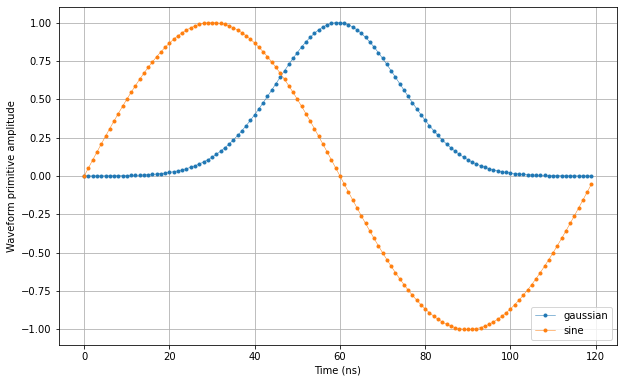

In [6]:
time = numpy.arange(0, max(map(lambda d: len(d["data"]), waveforms.values())), 1)
fig, ax = matplotlib.pyplot.subplots(1, 1, figsize=(10, 10 / 1.61))

for wf, d in waveforms.items():
    ax.plot(time[: len(d["data"])], d["data"], ".-", linewidth=0.5, label=wf)

ax.legend(loc=4)
ax.yaxis.grid()
ax.xaxis.grid()
ax.set_ylabel("Waveform primitive amplitude")
ax.set_xlabel("Time (ns)")

matplotlib.pyplot.draw()
matplotlib.pyplot.show()

Specify acquisitions
--------------------

We also need to specify the acquisitions so that the instrument can allocate the required memory for it's acquisition list. In this case we will create 5 acquisition specifications that
each create a single bin. However, we will not be using the bins in this turorial.

In [7]:
# Acquisitions
acquisitions = {
    "single": {"num_bins": 1, "index": 0},
    "multiple_0": {"num_bins": 1, "index": 1},
    "multiple_1": {"num_bins": 1, "index": 2},
    "multiple_2": {"num_bins": 1, "index": 3},
    "avg": {"num_bins": 1, "index": 4},
}

Create Q1ASM program
--------------------

Now that we have the waveforms and acquisitions specification for the sequence, we need a simple Q1ASM program that sequences and acquires the waveforms.

In [8]:
# Sequence program.
seq_prog = """
play    0,1,4     #Play waveforms and wait 4ns.
acquire 0,0,16380 #Acquire waveforms and wait remaining duration of scope acquisition.
stop              #Stop.
"""

Upload sequence
---------------

Now that we have the waveform and acquisition specifications and Q1ASM program, we can combine them in a sequence stored in a JSON file.

In [9]:
# Add sequence to single dictionary and write to JSON file.
sequence = {
    "waveforms": waveforms,
    "weights": {},
    "acquisitions": acquisitions,
    "program": seq_prog,
}
with open("sequence.json", "w", encoding="utf-8") as file:
    json.dump(sequence, file, indent=4)
    file.close()

Let's write the JSON file to the instruments. We will use sequencer 0, which will drive outputs $\text{O}^{[1-2]}$ and acquire on inputs $\text{I}^{[1-2]}$.

In [10]:
# Upload sequence.
qrm.sequencer0.sequence("sequence.json")

Play sequence
-------------

The sequence has been uploaded to the instrument. Now we need to configure the sequencers to trigger the acquisition with the `acquire` instruction.

In [11]:
# Configure the sequencer to trigger the scope acquisition.
qrm.scope_acq_sequencer_select(0)
qrm.scope_acq_trigger_mode_path0("sequencer")
qrm.scope_acq_trigger_mode_path1("sequencer")

# Map sequencer to specific outputs (but first disable all sequencer connections)
for sequencer in qrm.sequencers:
    for out in range(0, 2):
        sequencer.set("channel_map_path{}_out{}_en".format(out % 2, out), False)
qrm.sequencer0.channel_map_path0_out0_en(True)
qrm.sequencer0.channel_map_path1_out1_en(True)

Now let's start the sequence.

In [12]:
# Arm and start sequencer.
qrm.arm_sequencer(0)
qrm.start_sequencer()

# Print status of sequencer.
print("Status:")
print(qrm.get_sequencer_state(0))

Status:
Status: STOPPED, Flags: ACQ_SCOPE_DONE_PATH_0, ACQ_SCOPE_DONE_PATH_1, ACQ_BINNING_DONE


Retrieve acquisition
--------------------

The waveforms have now been sequenced on the outputs and acquired on the inputs. Lets make sure that the sequencer has finished it's acquisition and then retrieve the
resulting data. The acquisition data is stored in a temporary memory in the instrument's FPGA. We need to first move the data from this memory into the into the
instrument's acquisition list. From there we can retrieve it from the instrument.

In [13]:
# Wait for the acquisition to finish with a timeout period of one minute.
qrm.get_acquisition_state(0, 1)

# Move acquisition data from temporary memory to acquisition list.
qrm.store_scope_acquisition(0, "single")

# Get acquisition list from instrument.
single_acq = qrm.get_acquisitions(0)

Let's plot the result.

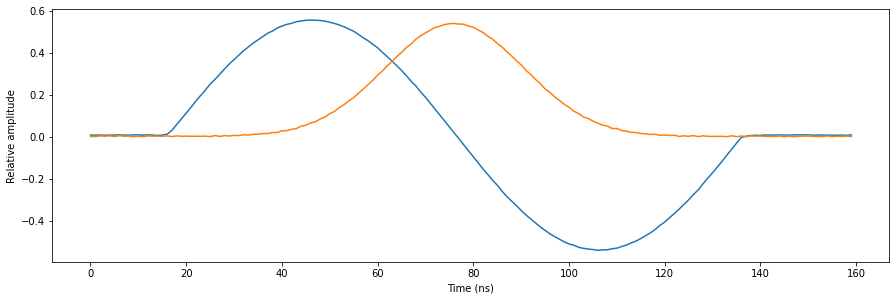

In [14]:
# Plot acquired signal on both inputs.
fig, ax = matplotlib.pyplot.subplots(1, 1, figsize=(15, 15 / 2 / 1.61))
ax.plot(single_acq["single"]["acquisition"]["scope"]["path0"]["data"][130:290])
ax.plot(single_acq["single"]["acquisition"]["scope"]["path1"]["data"][130:290])
ax.set_xlabel("Time (ns)")
ax.set_ylabel("Relative amplitude")
matplotlib.pyplot.show()

Retrieve multiple acquisitions
------------------------------

We can also run the sequence multiple times consecutively and store the acquisition data in the instrument's acquisition list before retrieving them all in
one go. To demonstrate this we will run the same sequence three times and vary the output gain for each run to create a clear distinction between the acquisitions.

In [15]:
# First run
qrm.sequencer0.gain_awg_path0(0.33)
qrm.sequencer0.gain_awg_path1(0.33)

qrm.arm_sequencer(0)
qrm.start_sequencer()

qrm.get_acquisition_state(0, 1)

qrm.store_scope_acquisition(0, "multiple_0")

# Second run
qrm.sequencer0.gain_awg_path0(0.66)
qrm.sequencer0.gain_awg_path1(0.66)

qrm.arm_sequencer(0)
qrm.start_sequencer()

qrm.get_acquisition_state(0, 1)

qrm.store_scope_acquisition(0, "multiple_1")

# Second run
qrm.sequencer0.gain_awg_path0(1)
qrm.sequencer0.gain_awg_path1(1)

qrm.arm_sequencer(0)
qrm.start_sequencer()

qrm.get_acquisition_state(0, 1)

qrm.store_scope_acquisition(0, "multiple_2")

# Get acquisition list from instrument.
multiple_acq = qrm.get_acquisitions(0)

Let's plot the result again.

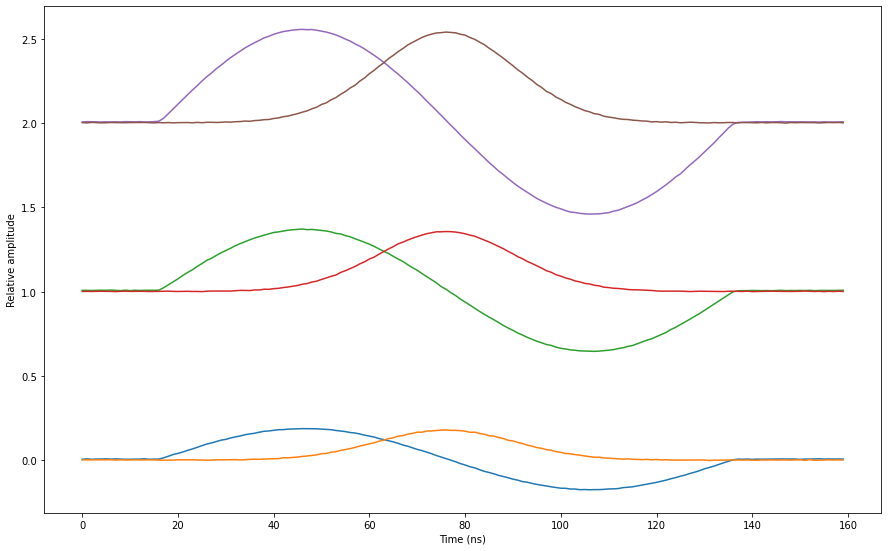

In [16]:
# Plot acquired signals (add acquisition index to separate acquisitions in plot).
fig, ax = matplotlib.pyplot.subplots(1, 1, figsize=(15, 15 / 1.61))
for acq_idx in range(0, 3):
    ax.plot(
        numpy.array(
            multiple_acq["multiple_{}".format(acq_idx)]["acquisition"]["scope"][
                "path0"
            ]["data"][130:290]
        )
        + acq_idx
    )
    ax.plot(
        numpy.array(
            multiple_acq["multiple_{}".format(acq_idx)]["acquisition"]["scope"][
                "path1"
            ]["data"][130:290]
        )
        + acq_idx
    )
    ax.set_xlabel("Time (ns)")
    ax.set_ylabel("Relative amplitude")
matplotlib.pyplot.show()

Hardware-based averaging
------------------------

We can also use hardware in the instrument itself to automatically accumulate acquisition data on-the-fly. This can be used to do averaging, by dividing the final
accumulated result by the number of accumulations. To use this feature, we first need to modify the Q1ASM to run the sequence multiple consecutive times.

In [17]:
# Sequence program.
seq_prog = """
      move    1000,R0   #Loop iterator.

loop: play    0,1,4     #Play waveforms and wait 4ns.
      acquire 4,0,16380 #Acquire waveforms and wait remaining duration of scope acquisition.
      loop    R0,@loop  #Run until number of iterations is done.

      stop              #Stop.
"""

Next, we need to program, configure and start the sequencer. This time we will also configure the sequencer to run in averaging mode.

In [18]:
# Add sequence to single dictionary and write to JSON file.
sequence = {
    "waveforms": waveforms,
    "weights": {},
    "acquisitions": acquisitions,
    "program": seq_prog,
}
with open("sequence_avg.json", "w", encoding="utf-8") as file:
    json.dump(sequence, file, indent=4)
    file.close()

# Upload sequence.
qrm.sequencer0.sequence("sequence_avg.json")

# Enable hardware averaging
qrm.scope_acq_avg_mode_en_path0(True)
qrm.scope_acq_avg_mode_en_path1(True)

# Arm and start sequencer.
qrm.arm_sequencer(0)
qrm.start_sequencer()

# Wait for sequence and acquisitions to finish.
qrm.get_acquisition_state(0, 1)

# Move accumulated result from temporary memory to the instrument's acquisition list.
qrm.store_scope_acquisition(0, "avg")

# Get acquisition list from instrument.
avg_acq = qrm.get_acquisitions(0)

The sequence has now run and accumulated a 1000 times. Time to finish the averaging process and print the result.

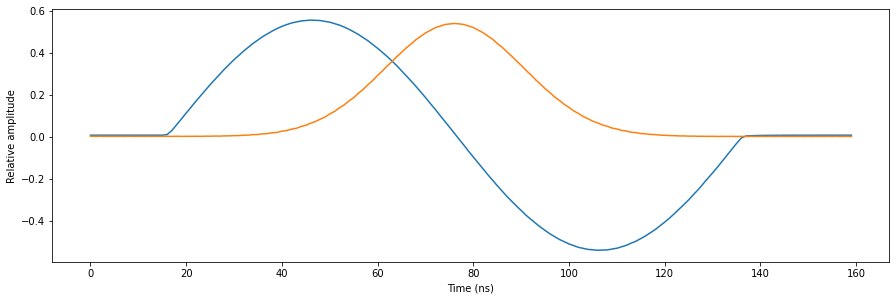

In [19]:
# Plot results.
fig, ax = matplotlib.pyplot.subplots(1, 1, figsize=(15, 15 / 2 / 1.61))
ax.plot(numpy.array(avg_acq["avg"]["acquisition"]["scope"]["path0"]["data"][130:290]))
ax.plot(numpy.array(avg_acq["avg"]["acquisition"]["scope"]["path1"]["data"][130:290]))
ax.set_xlabel("Time (ns)")
ax.set_ylabel("Relative amplitude")
matplotlib.pyplot.show()

Note that the accumulated acquisitions have already been averaged when the data is returned. The instrument keeps track of the number of accumulations and divides the result upon returning the data. The number of accumulations is also available for review.

In [20]:
# Print number of averages
print(avg_acq["avg"]["acquisition"]["scope"]["path0"]["avg_cnt"])
print(avg_acq["avg"]["acquisition"]["scope"]["path1"]["avg_cnt"])

1000
1000


To show that the hardware averaging worked, let's compare and zoom in on the data from the very first acquisition in this tutorial and the very last.

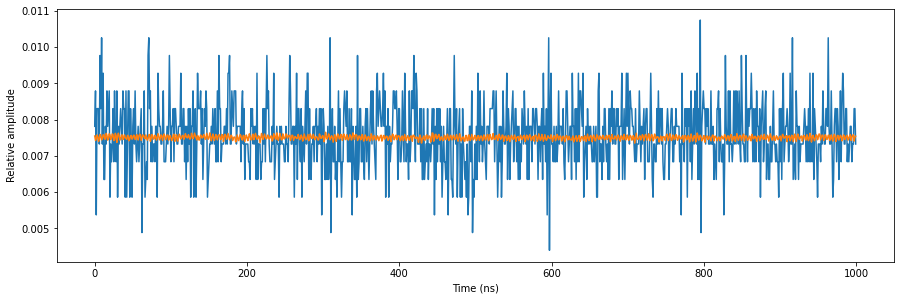

In [21]:
# Plot results
fig, ax = matplotlib.pyplot.subplots(1, 1, figsize=(15, 15 / 2 / 1.61))
ax.plot(
    numpy.array(
        single_acq["single"]["acquisition"]["scope"]["path0"]["data"][1000:2000]
    )
)
ax.plot(numpy.array(avg_acq["avg"]["acquisition"]["scope"]["path0"]["data"][1000:2000]))
ax.set_xlabel("Time (ns)")
ax.set_ylabel("Relative amplitude")
matplotlib.pyplot.show()

Stop
----

Finally, let's stop the sequencers if they haven't already and close the instrument connection. One can also display a detailed snapshot containing the instrument parameters before 
closing the connection by uncommenting the corresponding lines. 

In [ ]:
# Stop sequencer.
qrm.stop_sequencer()

# Print status of sequencer.
print(qrm.get_sequencer_state(0))
print()

# Uncomment the following to print an overview of the instrument parameters.
# Print an overview of the instrument parameters.
# print("Snapshot:")
# qrm.print_readable_snapshot(update=True)

# Close the instrument connection.
Pulsar.close_all()
Cluster.close_all()